#**Import**

In [1]:
import numpy as np
import sympy
from sympy import *
from IPython.display import display, Math
from skimage.transform import warp
import matplotlib.pyplot as plt
from PIL import Image
import scipy
from scipy import linalg, matrix
from scipy.interpolate import  griddata

print("Libraries imported")

Libraries imported


#**EX1**

##**1.1**
###**Construct three collinear points $P_1$, $P_2$ and $P_3$ and show they are on a line $l$.**

In order to construct 3 collinear points and to demonstrate that they lie on the same line, it is possible to directly select a line and extract the 3 points from it.

For example, from a line of coordinates $l = \begin{pmatrix}1& 2& 3\end{pmatrix}^T$: 



In [2]:
l = Matrix(3, 1, [1, 2, 3])
x1, x2, x3 = symbols('x1 x2 x3')
P = Matrix(1, 3, [x1, x2, x3])
print("Line equation:")
expr = P*l
display(Math(latex(expr)))
print("Solving for x1:")
sol1 = solve(expr, x1)
display(Math(latex(sol1)))

Line equation:


<IPython.core.display.Math object>

Solving for x1:


<IPython.core.display.Math object>

I can compute 3 points that lies on this line by defining 3 pairs of values for $x_2$ and $x_3$ and obtaining the corresponding values of $x_1$. \\
For instance, I chose:

In [3]:
P1 = Matrix(3, 1, [x1, 0, 1])
P2 = Matrix(3, 1, [x1, 1, 0])
P3 = Matrix(3, 1, [x1, 0, 2])
display(Math("P_1= "+latex(P1)+"\;\;\;\;\;\; P_2="+latex(P2)+"\;\;\;\;\;\; P_3= "+latex(P3)))

<IPython.core.display.Math object>

Solving these three I get:

In [4]:
P1[0] = solve(P1.T*l, x1)[x1]
P2[0] = solve(P2.T*l, x1)[x1]
P3[0] = solve(P3.T*l, x1)[x1]
display(Math("P_1= "+latex(P1)+"\;\;\;\;\;\; P_2="+latex(P2)+"\;\;\;\;\;\; P_3= "+latex(P3)))

<IPython.core.display.Math object>

I can demonstrate that a point lies in $l$ using: \\
>$P^Tl = 0 \implies P \in l$

Applying it to the 3 points:

In [5]:
if(P1.T*l == Matrix([[0]]) and P2.T*l == Matrix([[0]]) and P3.T*l == Matrix([[0]])):
  print("The 3 points ARE on the line ==> Okay")
else:
  print("The 3 points ARE NOT on the line")

The 3 points ARE on the line ==> Okay


##**1.2**
###**Show that if $H$ is a projective point trasformation, then the transformation applied to the points $P_1$, $P_2$ and $P_3$ and suitably to the line $l$ maps the points into points $P'_1$, $P'_2$ and $P'_3$ and the line into the line $l′$ such that $P'_1$, $P'_2$ and $P'_3$ are on $l′$.**

I am going to solve this problem numerically to simplify the notation. Nevertheless, it is obviously also simbolically solvable.

$H$ is a projective point matrix, therefore it must be non-singular:



In [6]:
h1, h2, h3, h4, h5, h6, h7, h8, h9 = symbols('h11 h12 h13 h21 h22 h23 h31 h32 h33', real =True)
H = Matrix(3, 3, [h1, h2, h3, h4, h5, h6, h7, h8, h9])
display(Math("H = " + latex(H)))

print("For instance, let us numerically define it as:")
H = Matrix(3, 3, [1, 0, 1, 0, 1, 1, 1, 1, 0])
display(Math("H = " + latex(H)))

print("H is non-singular when its determinant is ≠ 0:\n")
D = H.det()
display(Math("det(H) = "+latex(D)+"\implies ≠ 0"))

<IPython.core.display.Math object>

For instance, let us numerically define it as:


<IPython.core.display.Math object>

H is non-singular when its determinant is ≠ 0:



<IPython.core.display.Math object>

Using the point and line transformations: \\
> $P' = H*P $ \\
> $l' = H^{-T}*l$

I map $P_1$, $P_2$, $P_3$ and $l$ in $P'_1$, $P'_2$, $P'_3$ and $l′$:

In [7]:
P1_new = H*P1
P2_new = H*P2
P3_new = H*P3
l_new = H.T**-1 * l
display(Math("P'_1= "+latex(P1_new)+" \;\;\;\;\;\; P'_2="+latex(P2_new)+"\;\;\;\;\;\;P'_3= "+latex(P3_new)+"\;\;\;\;\;\;l' = "+latex(l_new)))

<IPython.core.display.Math object>

Again, I can demonstrate that these 3 new points lie in $l'$ using: \\
>$P'^Tl' = 0 \implies P' \in l'$

In [8]:
if(P1_new.T*l_new == Matrix([[0]]) and P2_new.T*l_new == Matrix([[0]]) and P3_new.T*l_new == Matrix([[0]])):
  print("The 3 new points ARE on the new line ==> Okay")
else:
  print("The 3 new points ARE NOT on the new line")

The 3 new points ARE on the new line ==> Okay


#**EX2**

**You want to recover parallel lines on the image so that the tiles appear to be parallel.**

This is the original distorted image:

(448, 640, 3)


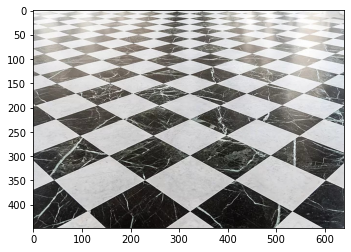

In [9]:
path = 'ex2_distorted_tiles.jpg'
img = np.array(Image.open(path))
print(img.shape)
plt.imshow(img)
plt.show()

##**2.1**
###**The homography $H_P=
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
l_1 & l_2 & l_3
\end{pmatrix}$, should map the vanishing line back to the line at infinity.**

###**The last row is the vanishing line $l$ (which you have to find).**


First of all, I manually selected 4 points which define 4 segments on the parallel sides of the tiles:

<IPython.core.display.Math object>

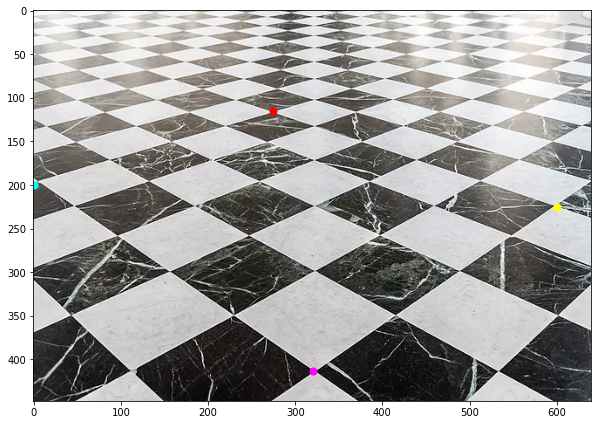

In [10]:
P1 = Matrix(3, 1, [0, 200, 1])
P2 = Matrix(3, 1, [320, 413, 1])
P3 = Matrix(3, 1, [600, 225, 1])
P4 = Matrix(3, 1, [275, 115, 1])
'''
# single tile coords
P1 = Matrix(3, 1, [230, 350, 1])
P2 = Matrix(3, 1, [322, 412, 1])
P3 = Matrix(3, 1, [415, 349, 1])
P4 = Matrix(3, 1, [323, 300, 1])
'''

display(Math("P1 = " + latex(P1) + "\;\;\;\;\;\; P2 = " + latex(P2) + "\;\;\;\;\;\; P3 = " + latex(P3) + "\;\;\;\;\;\; P4 = " + latex(P4)))
print('\n')

plt.figure(figsize=(10,10))

plt.scatter(P1[0], P1[1], marker='o', s=50, color='cyan')
plt.scatter(P2[0], P2[1], marker='o', s=50, color='magenta')
plt.scatter(P3[0], P3[1], marker='o', s=50, color='yellow')
plt.scatter(P4[0], P4[1], marker='o', s=50, color='red')

plt.imshow(img)
plt.show()

I computed (and normalized) the 4 lines on the parallel sides of the tiles by doing the cross product between the two points they pass through:

In [11]:
l1 = P1.cross(P2)
l1 = l1 / l1[2]

l2 = P2.cross(P3)
l2 = l2 / l2[2]

l3 = P3.cross(P4)
l3 = l3 / l3[2]

l4 = P4.cross(P1)
l4 = l4 / l4[2]

display(Math("l_1 = " + latex(l1) + "\;\;\;\;\;\; l_2 = " + latex(l2) + "\;\;\;\;\;\; l_3 = " + latex(l3) + "\;\;\;\;\;\; l_4 = " + latex(l4)))

<IPython.core.display.Math object>

Now I can compute the vanishing points as the intersections of the aforementioned lines and the vanishing line passing through the vanishing points:

In [12]:
V1 = l1.cross(l3)
V1 = V1 / V1[2]

V2 = l2.cross(l4)
V2 = V2 / V2[2]

vanishing_line = V1.cross(V2)
vanishing_line = vanishing_line / vanishing_line[2]

display(Math("V_1 = " + latex(V1) + "\;\;\;\;\;\; V_2 = " + latex(V2)+"\;\;\;\;\;\; l_v = " + latex(vanishing_line)))

<IPython.core.display.Math object>

Now I compute $H_P$ using the vanishing line coordinates as $H_P =\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
l_1 & l_2 & l_3
\end{pmatrix}$:



In [13]:
HP = Matrix(3, 3, [1, 0, 0, 0, 1, 0, vanishing_line[0], vanishing_line[1], vanishing_line[2]])
display(Math("H_P = " + latex(HP)))

<IPython.core.display.Math object>

##**2.2**
###**$H_A$ is any affine transformation.**

Let us now build any affine transformation, formulated as $H_A =
\begin{pmatrix}
a_{11} & a_{12} & t_x \\
a_{21} & a_{22} & t_y \\
0 & 0 & 1
\end{pmatrix}=
\begin{pmatrix}
A & t\\
0^T & 1
\end{pmatrix}$
where $A$ is a rotation matrix and $t$ represents a translation.

Assuming a rotation of $\theta = \frac{\pi}{4} = 45°$, I obtain:
- $a_{11} = \cos(\theta)$
- $a_{12} = -\sin(\theta)$
- $a_{21} = \sin(\theta)$
- $a_{22} = \cos(\theta)$
- $t_x = 0$
- $t_y = 0$

Therefore, $H_A =
\begin{pmatrix}
\cos(\frac{\pi}{4}) & -\sin(\frac{\pi}{4}) & 0 \\
\sin(\frac{\pi}{4}) & \cos(\frac{\pi}{4}) & 0 \\
0 & 0 & 1
\end{pmatrix}$

In [14]:
th = np.pi/4
HA = Matrix(3, 3, [np.cos(th), -np.sin(th), 0, np.sin(th), np.cos(th), 0, 0, 0, 1])
display(Math("H_A = " + latex(HA)))

<IPython.core.display.Math object>

##**2.3**
###**You have to define an homography $H = H_AH_P$.**
###**You want that the last row of H is $l$.**
###**Also, verify that $H^{-T}l^T$ results in the line at infinity $(0, 0, 1)^T$.**
###**Then apply $H_P$ to the image using Skimage.transform.warp function or the DLT algorithm.**

I now compute $H$ as $H = H_A H_P$

We can see that the last row of $H$ corresponds to the vanishing line's coordinates.

In [15]:
H = HA*HP
display(Math("H = " + latex(H)+"\;\;\;\;\;\; l_v = " + latex(vanishing_line)))

<IPython.core.display.Math object>

I must also verify that $H^{-T} l^T = (0,0,1)^T$:

In [16]:
display(Math("H^{-T} l^T = " + latex(((H.T)**-1) * vanishing_line)+'\implies Okay'))

<IPython.core.display.Math object>

Now, I can apply $H_P$ to the image using the skimage.transform.warp function:

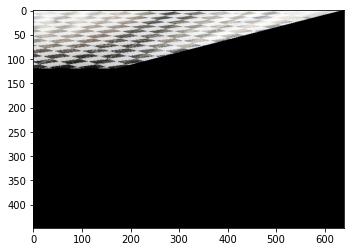

In [17]:
H_np = np.array(HP).astype(np.float64)
warped = warp(img, np.linalg.inv(H_np))
plt.imshow(warped)
plt.show()

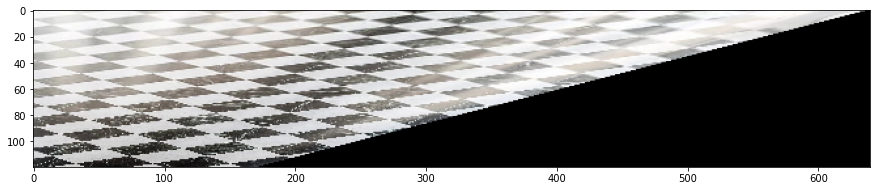

In [18]:
plt.figure(figsize=(15,15))
plt.imshow(warped[:120])
plt.show()

Now, let us use the given implementation of the DLT algorithm and adapt it to the lines case, simply by using the transformation computed before:

In [19]:
def image_rebound(mm, nn, hh):
    W = np.array([[1, nn, nn, 1 ],[1, 1, mm, mm],[ 1, 1, 1, 1]])
    ws = np.dot(hh,W)
    ### scaling
    xx = np.vstack((ws[2,:],ws[2,:],ws[2,:]))
    wsX =  np.round(ws/xx)
    bounds = [np.min(wsX[1,:]), np.max(wsX[1,:]),np.min(wsX[0,:]), np.max(wsX[0,:])]
    return bounds

def make_transform(imm, hh):   
    mm,nn = imm.shape[0],imm.shape[0]
    bounds = image_rebound(mm,nn,hh)
    nrows = bounds[1] - bounds[0]
    ncols = bounds[3] - bounds[2]
    s = max(nn,mm)/max(nrows,ncols)
    scale = np.array([[s, 0, 0],[0, s, 0], [0, 0, 1]])
    trasf = scale@hh
    trasf_prec =  np.linalg.inv(trasf)
    bounds = image_rebound(mm,nn,trasf)
    nrows = (bounds[1] - bounds[0]).astype(np.int)
    ncols = (bounds[3] - bounds[2]).astype(np.int)
    return bounds, nrows, ncols, trasf, trasf_prec

def get_new_image(nrows, ncols, imm, bounds, trasf_prec, nsamples):
    xx  = np.linspace(1, ncols, ncols)
    yy  = np.linspace(1, nrows, nrows)
    [xi,yi] = np.meshgrid(xx,yy) 
    a0 = np.reshape(xi, -1,order ='F')+bounds[2]
    a1 = np.reshape(yi,-1, order ='F')+bounds[0]
    a2 = np.ones((ncols*nrows))
    uv = np.vstack((a0.T,a1.T,a2.T)) 
    new_trasf = np.dot(trasf_prec,uv)
    val_normalization = np.vstack((new_trasf[2,:],new_trasf[2,:],new_trasf[2,:]))
   
    ### The new transformation
    newT = new_trasf/val_normalization
    
    ### 
    xi = np.reshape(newT[0,:],(nrows,ncols),order ='F') 
    yi = np.reshape(newT[1,:],(nrows,ncols),order ='F')
    cols = imm.shape[1]
    rows = imm.shape[0]
    xxq  = np.linspace(1, rows, rows).astype(np.int)
    yyq  = np.linspace(1, cols, cols).astype(np.int)
    [x,y] = np.meshgrid(yyq,xxq) 
    x = (x - 1).astype(np.int) #Offset x and y relative to region origin.
    y = (y - 1).astype(np.int) 
        
    ix = np.random.randint(imm.shape[1], size=nsamples)
    iy = np.random.randint(imm.shape[0], size=nsamples)
    samples = imm[iy,ix]
       
    int_im = griddata((iy, ix), samples, (yi,xi))
    
    #Plotting
    plt.figure(figsize=(10,10))
    plt.imshow(int_im.astype(np.uint8))
    plt.show()

This is the result obtained using the DLT algorithm:


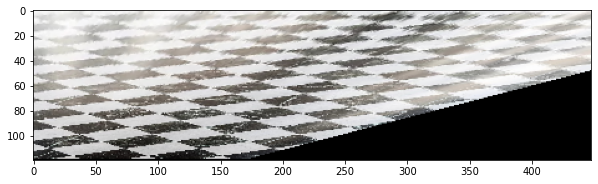

In [20]:
bounds, nrows, ncols,  trasf, trasf_prec = make_transform(img, H_np)     
nn, mm  = img.shape[0], img.shape[0]

if max(nn,mm)>1000:
    kk = 6
else: kk =5
nsamples = 10**kk

print("This is the result obtained using the DLT algorithm:")
get_new_image(nrows, ncols, img, bounds, trasf_prec, nsamples)

##**2.4**
###**After warping have we obtained a metric rectification? If not what would we need?**

No, we have not achieved a metric rectification: doing all these steps, we have managed to recover projective and affine distorsions performing an affine rectification, and therefore we have recovered parallel lines and planes.

However, we have not achieved metric rectification yet, because we are not able to compute metric properties, such as angles. To do this, we need to recover also the distorsion caused by similarity transformations. In particular, by using the absolute conic, we are able to recover angles, and therefore the metric structure of the scene.

#**EX3**

##**3.1**
###**Show that the ratio of length of parallel line segments is preserved.**

An affine transformation is a non-singular linear transformation $H_A =
\begin{pmatrix}
a_{11} & a_{12} & t_x \\
a_{21} & a_{22} & t_y \\
0 & 0 & 1
\end{pmatrix}$ where the ratio of lengths of parallel line segments is invariant. \\
I am going to solve this problem numerically to simplify the notation. Nevertheless, it is obviously also simbolically solvable.

To start, let us build two parallel lines considering 4 points:

In [21]:
P1 = Matrix(3, 1, [0, 0, 1])
P2 = Matrix(3, 1, [2, 0, 1])
s1 = Segment(P1, P2)
P3 = Matrix(3, 1, [0, 1, 1])
P4 = Matrix(3, 1, [1, 1, 1])
s2 = Segment(P3, P4)

display(Math("P_1= "+latex(P1)+"\;\;\;\;\;\; P_2="+latex(P2)+"\;\;\;\;\;\; P_3= "+latex(P3)+"\;\;\;\;\;\; P_4= "+latex(P4)))

l1 = P1.cross(P2)
l2 = P3.cross(P4)
lines_int = l1.cross(l2)

display(Math("l_1= "+latex(l1)+"\;\;\;\;\;\; l_2="+latex(l2)+"\;\;\;\;\;\; l_1∩l_2 = "+latex(lines_int)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$l_1$ is the line passing through $P_1$ and $P_2$. \\
$l_2$ is the line passing through $P_3$ and $P_4$. \\

The third coordinate of $l_1\cap l_2= 0 \implies$  $l_1$ and $l_2$ are parallel ($l_1\parallel l_2$). \\

$s_1$ is the segment linking $P_1$ and $P_2$. \\
$s_2$ is the segment linking $P_3$ and $P_4$. \\
The lengths of these two segments are given by:

$d_1 = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2} \quad \quad \quad d_2 = \sqrt{(x_4 - x_3)^2 + (y_4 - y_3)^2}$

And the ratio of length of these parallel line segments is:

$\frac{d_1}{d_2} = \frac{\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}}{\sqrt{(x_4 - x_3)^2 + (y_4 - y_3)^2}}$

Numerically:

In [22]:
print("Segments' lengths:")
display(Math("d_1 = "+ latex(s1.length)+" \;\;\;\;\;\; d_2="+latex(s2.length)))

ratio = s1.length/s2.length
print("The ratio of length of these parallel line segments is:")
display(Math("d_1/d_2 = "+ latex(ratio)))

Segments' lengths:


<IPython.core.display.Math object>

The ratio of length of these parallel line segments is:


<IPython.core.display.Math object>

Now, let us consider any affine transformation $H_A$ and apply it to the four points:

In [23]:
HA = Matrix(3, 3, [2, 1, 1, 1, 3, 2, 0, 0, 1])
display(Math("H_A= "+latex(HA)+"\;\;\;\;\;\;det(H_A) = "+latex(HA.det())+"\implies ≠ 0"))

P1_new = HA*P1
P2_new = HA*P2
s1_new = Segment(P1_new, P2_new)
P3_new = HA*P3
P4_new = HA*P4
s2_new = Segment(P3_new, P4_new)

display(Math("P'_1= "+latex(P1_new)+"\;\;\;\;\;\; P'_2="+latex(P2_new)+"\;\;\;\;\;\; P'_3= "+latex(P3_new)+"\;\;\;\;\;\; P'_4= "+latex(P4_new)))

l1_new = P1_new.cross(P2_new)
l2_new = P3_new.cross(P4_new)
lines_int_new = l1_new.cross(l2_new)

display(Math("l'_1= "+latex(l1_new)+"\;\;\;\;\;\; l'_2="+latex(l2_new)+"\;\;\;\;\;\; l'_1∩l'_2 = "+latex(lines_int_new)))

print("Segments' lenghts:")
display(Math("d'_1 = "+ latex(s1_new.length)+" \;\;\;\;\;\; d'_2="+latex(s2_new.length)))

ratio_new = s1_new.length/s2_new.length
print("The ratio of length of these parallel line segments is:")
display(Math("d'_1/d'_2 = "+ latex(ratio_new)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Segments' lenghts:


<IPython.core.display.Math object>

The ratio of length of these parallel line segments is:


<IPython.core.display.Math object>

In [24]:
if(ratio == ratio_new):
  display(Math("d_1/d_2 = d'_1/d'_2 \implies "+latex('The ratio of length of parallel line segments IS preserved.')))
else:
  print("The ratio of length of parallel line segments IS NOT preserved.")

<IPython.core.display.Math object>

##**3.2**
### **Show that a circle can be computed using 3 points plus the two circular points.**

Let us consider 2 circular points and 3 generic points (I am solving simbolically, but it can be easily switched to a numerical example uncommenting the "numerical example" block in the following cell):

In [25]:
a, d, e, f, i = symbols('a d e f i')
I = Matrix(3, 1, [1, i, 0])
J = Matrix(3, 1, [1, -i, 0])

x1, x2, x3, y1, y2, y3 = symbols('x1 x2 x3 y1 y2 y3')

# symbolic
P1 = Matrix(3, 1, [x1, y1, 1])
P2 = Matrix(3, 1, [x2, y2, 1])
P3 = Matrix(3, 1, [x3, y3, 1])

'''
# numerical example
P1 = Matrix(3, 1, [0, 1, 1])
P2 = Matrix(3, 1, [1, 0, 1])
P3 = Matrix(3, 1, [0, -1, 1])
'''
display(Math("P_1= "+latex(P1)+"\;\;\;\;\;\; P_2="+latex(P2)+"\;\;\;\;\;\; P_3= "+latex(P3)+"\;\;\;\;\;\; I= "+latex(I)+"\;\;\;\;\;\; J= "+latex(J)))

<IPython.core.display.Math object>

Given the generic circle equation (for points $P = \begin{pmatrix}x& y& z\end{pmatrix}^T$):

> $ax^2 + ay^2 + dxz + eyz + fz^2=0$

Inserting the 5 mentioned points in this equation, I get 5 contraints:

*   $ax_1^2 + ay_1^2 + dx_1 + ey_1 + f=0$
*   $ax_2^2 + ay_2^2 + dx_2 + ey_2 + f=0$
*   $ax_3^2 + ay_3^2 + dx_3 + ey_3 + f=0$
*   $a + ai^2=0 \implies a-a = 0$
*   $a + a(-i)^2=0\implies a-a = 0$





In [26]:
constraints_matrix = Matrix(5, 5, [P1[0]**2, P1[1]**2, P1[0], P1[1], 1,
                                   P2[0]**2, P2[1]**2, P2[0], P2[1], 1,
                                   P3[0]**2, P3[1]**2, P3[0], P3[1], 1,
                                   1**2, -1, 1*0, i*0, 0**2,
                                   1**2, -1, 1*0, (-i)*0, 0**2])
display(Math("constraints:"+latex(constraints_matrix) + '*' + latex(Matrix(5, 1, [a, a, d, e, f])) + ' = 0'))

<IPython.core.display.Math object>

The circle is determined to be the null vector of this 5 × 5 matrix:

In [27]:
null = constraints_matrix.nullspace(simplify=True)
display(Math(latex(null[0])))

<IPython.core.display.Math object>

#**EX4**
**Example 8.18 in the book**

The image of three squares provides sufficiently many constraints to compute $K$. Consider one of the squares. The correspondences between its four corner points and their images define the homography $H$ between the plane $\pi$ of the square and the image. Applying this homography to circular points on $\pi$ determines their images as $H(1, ±i, 0)^T$. Thus we have two points on the (as yet unknown) $\omega$. A similar procedure applied to the other squares generates a total of six points on $\omega$, from which it may be computed (since five points are required to determine a conic). In outline the algorithm has the following steps:

##**4.1**
###**For each square compute the homography $H$ that maps its corner points, $(0, 0)^T$, $(1, 0)^T$, $(0, 1)^T$, $(1, 1)^T$, to their imaged points. (The alignment of the plane coordinate system with the square is a similarity transformation and does not affect the position of the circular points on the plane).**

This is the starting image (3 squares which are not parallel and not orthogonal):

(708, 941, 4)


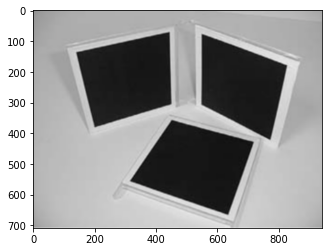

In [28]:
path = 'ex4_image.png'
img = np.array(Image.open(path))
print(img.shape)
plt.imshow(img)
plt.show()

I define the 4 corner points on the unitary square and the correspective coordinates of the 3 squares in the image:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

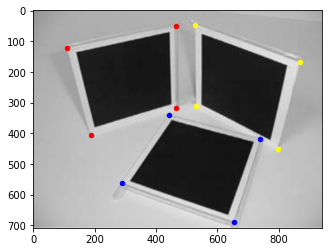

In [29]:
# Unitary square points
P1 = Matrix([0, 0, 1])
P2 = Matrix([1, 0, 1])
P3 = Matrix([0, 1, 1])
P4 = Matrix([1, 1, 1])

# Squares coordinates I manually obtained by checking the corners location on Microsoft Paint.
X1L = Matrix([110, 122, 1])
X2L = Matrix([465, 50, 1])
X3L = Matrix([187, 405, 1])
X4L = Matrix([464, 316, 1])

X1C = Matrix([443, 341, 1])
X2C = Matrix([740, 418, 1])
X3C = Matrix([290, 560, 1])
X4C = Matrix([653, 688, 1])

X1R = Matrix([528, 47, 1])
X2R = Matrix([870, 169, 1])
X3R = Matrix([530, 310, 1])
X4R = Matrix([796, 450, 1])

display(Math("P_1= "+latex(P1)+"\;\;\;\;\;\; P_2="+latex(P2)+"\;\;\;\;\;\; P_3= "+latex(P3)+"\;\;\;\;\;\; P_4= "+latex(P4)))
print('\n')

display(Math("x_{L1}= "+latex(X1L)+"\;\;\;\;\;\; x_{L2}="+latex(X2L)+"\;\;\;\;\;\; x_{L3}= "+latex(X3L)+"\;\;\;\;\;\; x_{L4}= "+latex(X4L)))
print('\n')

display(Math("x_{C1}= "+latex(X1C)+"\;\;\;\;\;\; x_{C2}="+latex(X2C)+"\;\;\;\;\;\; x_{C3}= "+latex(X3C)+"\;\;\;\;\;\; x_{C4}= "+latex(X4C)))
print('\n')

display(Math("x_{R1}= "+latex(X1R)+"\;\;\;\;\;\; x_{R2}="+latex(X2R)+"\;\;\;\;\;\; x_{R3}= "+latex(X3R)+"\;\;\;\;\;\; x_{R4}= "+latex(X4R)))
print('\n')

plt.imshow(img)

plt.scatter(X1L[0], X1L[1], color="red", s=20)
plt.scatter(X2L[0], X2L[1], color="red", s=20)
plt.scatter(X3L[0], X3L[1], color="red", s=20)
plt.scatter(X4L[0], X4L[1], color="red", s=20)

plt.scatter(X1C[0], X1C[1], color="blue", s=20)
plt.scatter(X2C[0], X2C[1], color="blue", s=20)
plt.scatter(X3C[0], X3C[1], color="blue", s=20)
plt.scatter(X4C[0], X4C[1], color="blue", s=20)

plt.scatter(X1R[0], X1R[1], color="yellow", s=20)
plt.scatter(X2R[0], X2R[1], color="yellow", s=20)
plt.scatter(X3R[0], X3R[1], color="yellow", s=20)
plt.scatter(X4R[0], X4R[1], color="yellow", s=20)

Now, I have to compute the three homographies $H_L$, $H_C$ and $H_R$ that maps the points of the 3 squares of the image into the unitary square: to do so, I am going to apply the DLT algorithm step by step.

First, I compute the $A_i$ matrices for each square:

In [30]:
def computeA(M, N):
  A = zeros(3, 9)
  A[0, 3:6] = (-M[2]*N).T
  A[0, 6:9] = (M[1]*N).T
  A[1, 6:9] = (-M[0]*N).T
  A[1, 0:3] = -A[0, 3:6]
  A[2, 0:3] = -A[0, 6:9]
  A[2, 3:6] = -A[1, 6:9]
  return A

P = [P1, P2, P3, P4]
L = [X1L, X2L, X3L, X4L]
C = [X1C, X2C, X3C, X4C]
R = [X1R, X2R, X3R, X4R]

A1L = computeA(L[0], P[0])
A2L = computeA(L[1], P[1])
A3L = computeA(L[2], P[2])
A4L = computeA(L[3], P[3])

display(Math('A_i'+ latex(' matrices (i = 1, 2, 3, 4) for left square:')))
print('\n')
display(Math('A_{L1}='+latex(A1L)))
display(Math('A_{L2}='+latex(A2L)))
display(Math('A_{L3}='+latex(A3L)))
display(Math('A_{L4}='+latex(A4L)))

A1C = computeA(C[0], P[0])
A2C = computeA(C[1], P[1])
A3C = computeA(C[2], P[2])
A4C = computeA(C[3], P[3])

print('\n')
display(Math('A_i'+ latex(' matrices (i=1,2,3,4) for center square:')))
print('\n')
display(Math('A_{C1}='+latex(A1C)))
display(Math('A_{C2}='+latex(A2C)))
display(Math('A_{C3}='+latex(A3C)))
display(Math('A_{C4}='+latex(A4C)))

A1R = computeA(R[0], P[0])
A2R = computeA(R[1], P[1])
A3R = computeA(R[2], P[2])
A4R = computeA(R[3], P[3])

print('\n')
display(Math('A_i'+ latex(' matrices (i=1,2,3,4) for right square:')))
print('\n')
display(Math('A_{R1}='+latex(A1R)))
display(Math('A_{R2}='+latex(A2R)))
display(Math('A_{R3}='+latex(A3R)))
display(Math('A_{R4}='+latex(A4R)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now, for each square I assemble the 4 matrices into 1 big matrix:

In [31]:
AL = zeros(12,9)
AL[0:3,0:] = A1L
AL[3:6,0:] = A2L
AL[6:9,0:] = A3L
AL[9:12,0:] = A4L

AC = zeros(12,9)
AC[0:3,0:]= A1C
AC[3:6,0:] = A2C
AC[6:9,0:] = A3C
AC[9:12,0:] = A4C

AR = zeros(12,9)
AR[0:3,0:] = A1R
AR[3:6,0:] = A2R
AR[6:9,0:] = A3R
AR[9:12,0:] = A4R

display(Math('A_L='+latex(AL)))
print('\n')
display(Math('A_C='+latex(AC)))
print('\n')
display(Math('A_R='+latex(AR)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now I compute the null space for each of these matrices, obtaining $9\times1$ vectors, which are the vectorized version of the desired $3\times3$ homographies:

In [32]:
hL = AL.nullspace()[0]
hC = AC.nullspace()[0]
hR = AR.nullspace()[0]

display(Math(latex('Null space of ')+'A_L:\;\;\;\;\;\;'+'h_L='+latex(hL.evalf(4))+'\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;'+latex('I test the null space:')+'\;\;\;\;\;\;A_L*h_L='+latex(AL*hL)))
print("\n")

display(Math(latex('Null space of ')+'A_C:\;\;\;\;\;\;'+'h_C='+latex(hC.evalf(4))+'\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;'+latex('I test the null space:')+'\;\;\;\;\;\;A_C*h_C='+latex(AC*hC)))
print("\n")

display(Math(latex('Null space of ')+'A_R:\;\;\;\;\;\;'+'h_R='+latex(hR.evalf(4))+'\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;'+latex('I test the null space:')+'\;\;\;\;\;\;A_R*h_R='+latex(AR*hR)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now I reshape the $9\times1$ vectors to get the desired $3\times3$ homographies:

In [33]:
HL = zeros(3,3)
HL[:,0] = hL[0:3]
HL[:,1] = hL[3:6]
HL[:,2] = hL[6:9]
HL = HL.T
HL = N(HL,4)

HC = zeros(3,3)
HC[:,0] = hC[0:3]
HC[:,1] = hC[3:6]
HC[:,2] = hC[6:9]
HC = HC.T
HC = N(HC,4)

HR = zeros(3,3)
HR[:,0] = hR[0:3]
HR[:,1] = hR[3:6]
HR[:,2] = hR[6:9]
HR = HR.T
HR = N(HR,4)

display(Math(latex('Homography for the left square:')+'\;\;\;\;\;\;H_L='+latex(HL)))
print("\n")

display(Math(latex('Homography for the center square:')+'\;\;\;\;\;\;H_C='+latex(HC)))
print("\n")

display(Math(latex('Homography for the right square:')+'\;\;\;\;\;\;H_R='+latex(HR)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now I check if these are truly the correct homographies by multiplying them for the corners of the unit square and see if they are mapped into the points in the image:

In [34]:
print("Checks for left square:\n")
display(Math('H_L*P_1='+latex(HL*P1)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{L1} = '+latex(X1L)))
print('\n')
display(Math('H_L*P_2='+latex(HL*P2)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{L2} = '+latex(X2L)))
print('\n')
display(Math('H_L*P_3='+latex(HL*P3)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{L3} = '+latex(X3L)))
print('\n')
display(Math('H_L*P_4='+latex(HL*P4)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{L4} = '+latex(X4L)))

print("\n\nChecks for center square:\n")
display(Math('H_C*P_1='+latex(HC*P1)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{C1} = '+latex(X1C)))
print('\n')
display(Math('H_C*P_2='+latex(HC*P2)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{C2} = '+latex(X2C)))
print('\n')
display(Math('H_C*P_3='+latex(HC*P3)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{C3} = '+latex(X3C)))
print('\n')
display(Math('H_C*P_4='+latex(HC*P4)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{C4} = '+latex(X4C)))

print("\n\nChecks for right square:\n")
display(Math('H_R*P_1='+latex(HR*P1)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{R1} = '+latex(X1R)))
print('\n')
display(Math('H_R*P_2='+latex(HR*P2)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{R2} = '+latex(X2R)))
print('\n')
display(Math('H_R*P_3='+latex(HR*P3)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{R3} = '+latex(X3R)))
print('\n')
display(Math('H_R*P_4='+latex(HR*P4)+'\;\;\;\;\;\;'+latex('which, after normalization, is exactly ')+'X_{R4} = '+latex(X4R)))

Checks for left square:



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>



Checks for center square:



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>



Checks for right square:



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

##**4.2**
###**Compute the imaged circular points for the plane of that square as $H(1, ±i, 0)^T$. Writing $H = [h_1, h_2, h_3]$, the imaged circular points are $h_1 ± ih_2$.**

Now, from these 3 homographies, I have to compute the 6 imaged circular points:

In [35]:
I = Matrix([1, sympy.I, 0])
J = Matrix([1, -sympy.I, 0])

display(Math(latex('The circular points are:')+"\;\;\;\;\;\; I="+latex(I)+"\;\;\;\;\;\; J= "+latex(J)))
print('\n')
display(Math(latex('The 6 imaged circular points are:')))
print('\n')
display(Math('I_L=H_L*I='+latex(HL*I)+'\;\;\;\;\;\;\;\;\;\;\;\; J_L=H_L*J='+latex(HL*J)))
print('\n')
display(Math('I_C=H_C*I='+latex(HC*I)+'\;\;\;\;\;\;\;\;\;\;\;\; J_C=H_C*J='+latex(HC*J)))
print('\n')
display(Math('I_R=H_R*I='+latex(HR*I)+'\;\;\;\;\;\;\;\;\;\;\;\; J_R=H_R*J='+latex(HR*J)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

##**4.3**
###**Fit a conic $\omega$ to the six imaged circular points. The constraint that the imaged circular points lie on $\omega$ may be rewritten as two real constraints. If $h_1 ± ih_2$ lies on $\omega$ then $(h_1 ± ih_2)^T \omega (h_1 ± ih_2)=0$, and the imaginary and real parts give respectively:**

> **$h_1^T \omega h_2 = 0$ and $h_1^T \omega h_1 = h_2^T \omega h_2$**


###**which are equations linear in $\omega$. The conic $\omega$ is determined up to scale from five or more such equations.**




Now I fit a conic $\omega$ to the 6 imaged circular point I just found. I do so computing the conic which satisfies our constraints:

In [36]:
a, b, c, d, e, f = symbols('a, b, c, d, e, f', real = True)
W = Matrix([[a, b/2, d/2],
            [b/2, c, e/2],
            [d/2, e/2, f]])

display(Math(latex('Generic conic:')+latex(W)))

h1l, h2l = HL[:,0], HL[:,1]
h1c, h2c = HC[:,0], HC[:,1]
h1r, h2r = HR[:,0], HR[:,1]
m1 = (h1l.T)*W*(h2l)
m2 = (h1l.T)*W*(h1l) - (h2l.T)*W*(h2l)
m3 = (h1c.T)*W*(h2c)
m4 = (h1c.T)*W*(h1c) - (h2c.T)*W*(h2c)
m5 = (h1r.T)*W*(h2r)
expr = Matrix([[m1],[m2],[m3],[m4],[m5]])

display(Math(latex('Our constraints:')+latex(Eq(expr, zeros(6,1), evaluate=False))))

expr = solve(expr)
W=W.subs([(a, expr[a]), (b, expr[b]), (c, expr[c]), (d, expr[d]), (e, expr[e]), (f, 1)]) # f value set to 1

display(Math(latex('The conic I get (choosing f=1):')+'\;\;\;\;\;\;\omega = '+latex(W.evalf(4))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

##**4.4**
###**Compute the calibration $K$ from $\omega = (KK^T)^{−1}$ using the Cholesky factorization.**

Now, I get $K$ through Cholesky factorization. I can directly apply it to $\omega$ since it is positive-definite:

In [37]:
W_inv = W.inv()
W_inv = W_inv.evalf(4)
K = W_inv.cholesky()

display(Math(latex('K = ')+latex(K)))
print('\n')
display(Math(latex('Check for ')+ '\omega = (K*K^T)^{-1}:\;\;\;\;\;'+latex(Eq(W.evalf(4), ((K*K.T).inv()).evalf(4), evaluate=False))+'\implies Okay'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>